In [1]:
import re
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.signal as signal
from datetime import datetime
from scipy import signal

---
>> **HOMEWORK**
>>
>>
>> Download unique city (I chose **Vienna**)
>> 1. Get top 10 landlords (most owned places, biggest salary when all places occupied) +
>> 2. How the prices change if we go for a week or month (listings) +
>> 3. How the apartment price depends on the evaluation of the location? What about cleanliness or other type of evaluations? +
>> 4. Find superhosts. What part of all the landlords are superhosts. +
>> 5. Longest comment (reviews_details) +
>> 6. Most commented apartment +
>> 7. From comment dates (reviews) report when there are most tourists in the city (plot comments vs dates) +
>> 8. Find which district in the moste expensice to stay at on average. +
>> 9. Sort available listings into listings with high, middle and low availability. +
>> 10. Create a map of all listings that are cheaper than 200 euros per night. +
>>
---


In [2]:
listings = pd.read_csv("~/Documents/bioa/data/Vienna/listings.csv", index_col="id")
listings_details = pd.read_csv(
    "~/Documents/bioa/data/Vienna/listings_details.csv",
    index_col="id",
    low_memory=False,)

In [9]:
calendar = pd.read_csv(
    "~/Documents/bioa/data/Vienna/calendar.csv",
    parse_dates=["date"],
    index_col=["listing_id"],)

In [4]:
reviews = pd.read_csv(
    "~/Documents/bioa/data/Vienna/reviews.csv",
    parse_dates=["date"],
    index_col=["listing_id"],)

In [5]:
reviews_details = pd.read_csv(
    "~/Documents/bioa/data/Vienna/reviews_details.csv",
    parse_dates=["date"],
    index_col=["listing_id"],)

In [6]:
pd.set_option("display.max_column", 500)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_seq_items", 500)
pd.set_option("display.max_colwidth", 500)
pd.set_option("expand_frame_repr", True)

In [7]:
target_columns = [
    "property_type",
    "accommodates",
    "first_review",
    "review_scores_value",
    "review_scores_cleanliness",
    "review_scores_location",
    "review_scores_accuracy",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_rating",
    "maximum_nights",
    "listing_url",
    "host_is_superhost",
    "host_about",
    "host_response_time",
    "host_response_rate",
    "street",
    "weekly_price",
    "monthly_price",
    "market",
]
listings = listings = pd.merge(listings, listings_details[target_columns], on="id", how="left")

In [83]:
listings.head(1)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15883,b&b near Old Danube river,62142,Eva,NaN,Donaustadt,48.24262,16.42767,Hotel room,85,1,11,2020-02-19,0.18,4,350,Bed and breakfast,3,2015-04-10,9.0,10.0,9.0,10.0,10.0,10.0,95.0,365,https://www.airbnb.com/rooms/15883,f,Mein größtes Hobby: Reisen! Am liebsten mit meinen 3 Kindern um ihnen die weite Welt zu zeigen. Eindrücke von allen möglichen Orten finden so Einfluss im Design vom the rooms. Ich freue mich auf neue Begegnungen!,within an hour,100%,"Vienna, Vienna, Austria",NaN,NaN,Vienna


In [10]:
#1
# Top 10 by apartment count
freq = (
    listings.groupby(["host_id"])
    .size()
    .reset_index(name="Apartment count"))
freq = freq.sort_values(by=["Apartment count"], ascending=False)
freq[:10]

,host_id,Apartment count
368,2816192,99
1052,8632750,91
1675,15935294,82
563,4331202,73
555,4304771,59
741,5874520,58
48,518644,52
116,1108400,43
6700,238252274,43
3638,50945012,42


In [11]:
#Top 10 by salary
salary = pd.merge(listings["host_id"], listings["monthly_price"], on="id", how="left")

In [12]:
salary.monthly_price = salary.monthly_price.str.replace(",", "")
salary["monthly_price"] = pd.to_numeric(salary["monthly_price"].str.strip("$"))

In [13]:
salary=(salary.groupby(["host_id"]).sum().rename(columns={'monthly_price': 'Monthly salary'}))
salary = salary.sort_values(by=["Monthly salary"], ascending=False)
salary[:10]

,Monthly salary
host_id,
14617312,100000.0
8632750,57560.0
9158703,49449.0
4304771,48800.0
5874520,29123.0
13951194,28300.0
2414813,27200.0
175131,19885.0
27775775,19800.0


In [14]:
#Top ten by apartment count AND salary
topten = pd.merge(freq, salary, on="host_id", how="left")
topten = topten.sort_values(by=["Monthly salary", "Apartment count"], ascending=False)
topten[:10]

,host_id,Apartment count,Monthly salary
4456,14617312,1,100000.0
1,8632750,91,57560.0
12,9158703,37,49449.0
4,4304771,59,48800.0
5,5874520,58,29123.0
36,13951194,17,28300.0
83,2414813,11,27200.0
53,175131,15,19885.0
14,27775775,37,19800.0
6,518644,52,16073.0


In [15]:
#2
listings.weekly_price = listings.weekly_price.str.replace(",", "")
listings["weekly_price"] = pd.to_numeric(listings["weekly_price"].str.strip("$"))
listings.monthly_price = listings.monthly_price.str.replace(",", "")
listings["monthly_price"] = pd.to_numeric(listings["monthly_price"].str.strip("$"))

In [16]:
priceperday = pd.merge(listings["price"], listings["weekly_price"], on="id", how="left")
priceperday ['Price for a day if you stay for a week'] = round(priceperday["weekly_price"]/7)
priceperday ['Cheaper by % to stay for a week'] = round(((listings["price"]-(priceperday["weekly_price"]/7))*100)/listings["price"])
priceperday = pd.merge(priceperday, listings["monthly_price"], on="id", how="left")
priceperday ['Price for a day if you stay for a month'] = round(priceperday["monthly_price"]/30.5) #took the average lenght of the month fromm google
priceperday ['Cheaper by % to stay for month'] = round(((listings["price"]-(priceperday["monthly_price"]/30.5))*100)/listings["price"])
priceperday.head()

,price,weekly_price,Price for a day if you stay for a week,Cheaper by % to stay for a week,monthly_price,Price for a day if you stay for a month,Cheaper by % to stay for month
id,,,,,,,
15883,85,NaN,NaN,NaN,NaN,NaN,NaN
38768,65,440.0,63.0,3.0,1440.0,47.0,27.0
40625,130,600.0,86.0,34.0,1895.0,62.0,52.0
51287,60,500.0,71.0,-19.0,850.0,28.0,54.0
70568,59,350.0,50.0,15.0,1100.0,36.0,39.0


In [17]:
priceplotday = priceperday["price"].mean()
priceplotweek = priceperday["Price for a day if you stay for a week"].mean()
priceplotmonth = priceperday["Price for a day if you stay for a month"].mean()
pricesinvienna=[priceplotday, priceplotweek, priceplotmonth]
yvienna=[1, 7, 30.5]

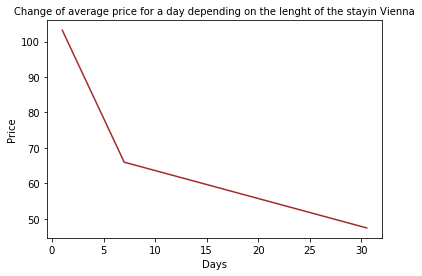

In [18]:
plt.plot(yvienna, pricesinvienna, color="brown")
plt.title("Change of average price for a day depending on the lenght of the stayin Vienna", fontsize=10, color="black")
plt.xlabel("Days", fontsize=10, color="black");
plt.ylabel("Price",fontsize=10, color="black")
plt.show()

In [20]:
#3
listings.price = listings.price.str.replace(",", "")
listings["price"] = pd.to_numeric(listings["price"].str.strip("$"))

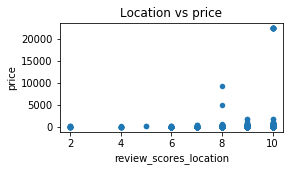

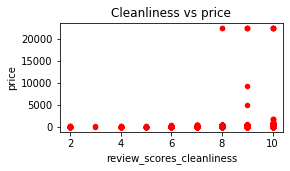

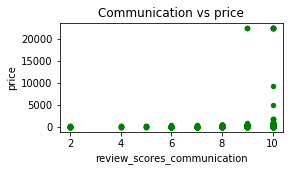

In [100]:
listings.plot.scatter(figsize=(4,2), y="price", x="review_scores_location", title="Location vs price")
listings.plot.scatter(figsize=(4,2), y="price", x="review_scores_cleanliness", color="red", title="Cleanliness vs price")
listings.plot.scatter(figsize=(4,2), y="price", x="review_scores_communication", color="green", title="Communication vs price")

In [21]:
#4
host = (
    freq.groupby(["Apartment count"])["host_id"]
    .count()
    .reset_index(name="Number of hosts"))

#Top 10 superhosts are:
freq[:10]

,host_id,Apartment count
368,2816192,99
1052,8632750,91
1675,15935294,82
563,4331202,73
555,4304771,59
741,5874520,58
48,518644,52
116,1108400,43
6700,238252274,43
3638,50945012,42


In [20]:
#4
#percentage of superhosts from all the hosts
superhost=(host[host["Apartment count"] > 1].sum() / host.sum())["Number of hosts"]*100
f'Superhosts are {superhost} % of all the hosts'

'Superhosts are 20.32213413866868 % of all the hosts'

In [92]:
#5
commentlen=reviews_details['comments'].str.len()
reviews_details['Lenght of comment'] = commentlen
reviews_details = reviews_details.sort_values(by=["Lenght of comment"], ascending=False)
reviews_details.head(1)

,id,date,reviewer_id,reviewer_name,comments,Lenght of comment
listing_id,,,,,,
22313216,523324791,2019-09-03,119240210,Niko,"Wir haben knapp mehr als eine Woche in Wien in der Wohnung verbracht. Die Wohnung befindet sich im 5. Bezirk, dieser ist zentru (Hidden by Airbnb) ah, hat viele Lebensmitteldiscounter, bietet einige Restaurants und Imbisse, falls es für andere Leute wichtig ist zu wissen, der Bezirk eher migrantisch geprägt. \nDie Schlüsselübergabe hat sehr gut geklappt. Wir wurden in der Wohnung von Chris empfangen, dieser hat uns den Schlüssel ausgehändigt und uns knapp in die Wohnung eingewiesen.\nDie Al...",5908.0


In [93]:
f'The longest comment is: {reviews_details.iloc[0, -2][0:500]}...'      #Showing just a part of the comment to save space     

'The longest comment is: Wir haben knapp mehr als eine Woche in Wien in der Wohnung verbracht. Die Wohnung befindet sich im 5. Bezirk, dieser ist zentru (Hidden by Airbnb) ah, hat viele Lebensmitteldiscounter, bietet einige Restaurants und Imbisse, falls es für andere Leute wichtig ist zu wissen,  der Bezirk eher migrantisch geprägt. \nDie Schlüsselübergabe hat sehr gut geklappt. Wir wurden in der Wohnung von Chris empfangen, dieser hat uns den Schlüssel ausgehändigt und uns knapp in die Wohnung eingewiesen.\nDie Altbauwo...'

In [94]:
#6
mostcom = (
    reviews_details.groupby(["listing_id"])
    .size()
    .reset_index(name="Comments count"))
mostcom = mostcom.sort_values(by=["Comments count"], ascending=False)
f'Most commented apartment is ID {mostcom.iloc[0, -2]} that was commented {mostcom.iloc[0, -1]} times' 
#Showing just the ID of the most commented apartment and not the top ten

'Most commented apartment is ID 24364665 that was commented 611 times'

In [95]:
#7
reviews.head(1)

,date
listing_id,
15883,2015-04-10


In [27]:
datesofreviews = (
    reviews.groupby(["date"])
    .size()
    .reset_index(name="Comments made that day"))

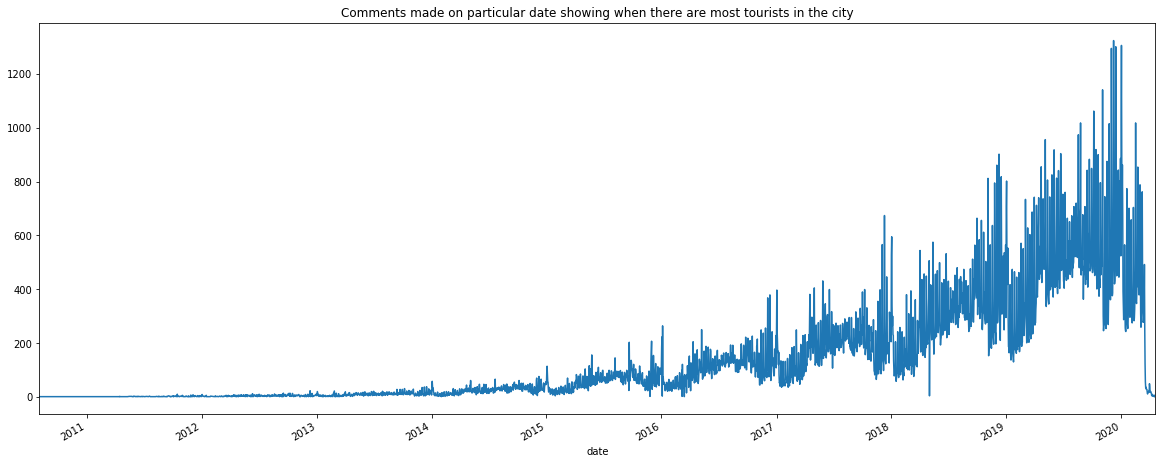

In [102]:
datesofreviews.plot(figsize=(20,8), y="Comments made that day", x="date", title="Comments made on particular date showing when there are most tourists in the city", legend="")

In [29]:
#8
expensivdistr = pd.merge(listings["neighbourhood"], listings["price"], on="id", how="left")
expensivdistr = (expensivdistr.groupby(["neighbourhood"]).mean().rename(columns={'price': 'Average price of one-night stay'}))
expensivdistr = expensivdistr.sort_values(by=["Average price of one-night stay"], ascending=False)

In [38]:
expensivdistr.plot.barh(figsize=(15, 7), color="orange", width=0.5)
plt.title("Average price of one-night stay in all districts", fontsize=13, color="blue")
plt.xlabel("Average price of one-night stray", fontsize=10, color="blue");
plt.ylabel("Neighbourhood",fontsize=10, color="blue")

In [31]:
#9
#high availability >80 days/year
#normal availability <80 and > 40 days/year
#low availability 40 < days/year

In [32]:
availability = (
    calendar[calendar.available == "t"]
    .groupby(["listing_id"])
    .size()
    .to_frame(name="available")
    .reset_index()
)
availability.head(3)

,listing_id,available
0,15883,350
1,38768,193
2,40625,341


In [33]:
#count
middle=sum((availability['available']>40) & (availability['available']<80))
high=sum((availability['available']>80))
low=sum((availability['available']<40))
all=len(availability.available)

In [34]:
availabilitycount=pd.DataFrame([high, middle, low], columns=['Count of places'], index=["High (>80 days/year)","Middle (<40 and >80 days/year)", "Low (<40 days/year)" ])
availabilitycount

,Count of places
High (>80 days/year),7773
Middle (<40 and >80 days/year),827
Low (<40 days/year),703


Text(0, 0.5, 'Availability')

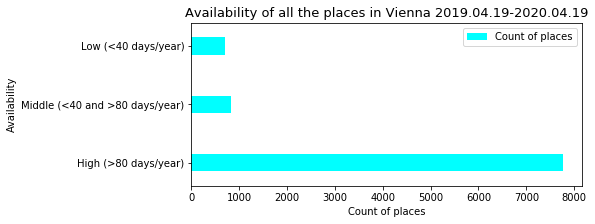

In [74]:
availabilitycount.plot.barh(figsize=(7, 3), color="aqua", width=0.3)
plt.title("Availability of all the places in Vienna 2019.04.19-2020.04.19", fontsize=13)
plt.xlabel("Count of places", fontsize=10)
plt.ylabel("Availability",fontsize=10)

In [36]:
#10
prices = listings.sort_values(by=["price"], ascending=True)
prices = prices.loc[prices['price'] < 200] 
prices.tail(1)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,property_type,accommodates,first_review,review_scores_value,review_scores_cleanliness,review_scores_location,review_scores_accuracy,review_scores_communication,review_scores_checkin,review_scores_rating,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
30816048,Design Apartment for 3 Guests 1.02,14070533,Prestige Apartments Sabrina,NaN,Josefstadt,48.21467,16.34754,Entire home/apt,199,2,1,2019-08-25,0.13,28,0,Serviced apartment,3,2019-08-25,8.0,10.0,8.0,10.0,10.0,10.0,100.0,1125,https://www.airbnb.com/rooms/30816048,t,Doing what you like is freedom - liking what you do is happiness\r\n,within an hour,100%,"Vienna, Wien, Austria",NaN,NaN,Vienna


Text(0, 0.5, 'Longitude')

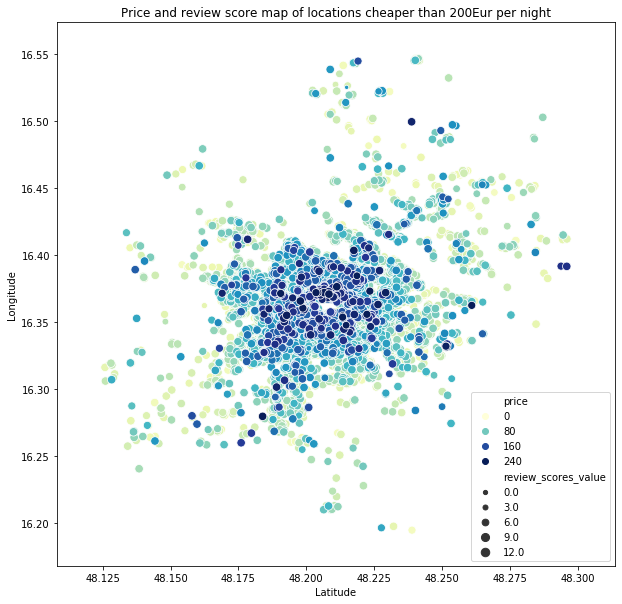

In [37]:
lats = prices["latitude"].tolist()
lons = prices["longitude"].tolist()
locations = list(zip(lats, lons))
plt.figure(figsize=(10, 10))
map1=sns.scatterplot(
    x=lats,
    y=lons,
    size=prices["review_scores_value"],
    hue=prices["price"],
    s=20,
    palette="YlGnBu",);
plt.title("Price and review score map of locations cheaper than 200Eur per night")
plt.xlabel("Latitude");
plt.ylabel("Longitude")